# Segmentación de clientes bancarios - Banco Alemán

En este documento se realizará la segmentación de clientes de un banco Alemán utilizando técnicas de clustering (K-mean y 
K-prototypes) y clasificación (Random Forest). Las librerias usadas acá son las siguientes
* [pandas](https://pandas.pydata.org/) - manipulación de data frames
* [numpy](http://www.numpy.org/) - operaciones álgebraicas
* [matplotlib](https://matplotlib.org/) - herramienta base para visualización
* [seaborm](https://seaborn.pydata.org/) - visualización avanzada
* [scikit-learn](https://scikit-learn.org/stable/) - herramientas de ML
* [kmodes](https://pypi.org/project/kmodes/) - implementación del algortimo K-prototypes

In [1]:
# Instalación de la libreria kmodes
!pip install kmodes

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.stats as stats
from mpl_toolkits.mplot3d import Axes3D 
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from kmodes.kprototypes import KPrototypes

**Lectura de datos**

Cambiar la siguiente instrucción según convenga para poder replicar los procedimientos


In [3]:
# credit_data = pd.read_csv('german_credit_data.csv')
# Carga de archivo - Mount
from google.colab import drive

drive.mount('/content/drive')
PATH = "/content/drive/MyDrive/Public/german_credit_data.csv"
credit_data = pd.read_csv(PATH)

Mounted at /content/drive


Descripción general del data frame

In [4]:
credit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
dtypes: int64(5), object(5)
memory usage: 78.2+ KB


La primera columna es un índice, se elimina. Sin contar la anterior, dos de ocho tienen entradas nulas. Asumo que el 
cliente no posee alguna de estás cuentas. 
Respecto al tipo de variables se observa que aquellas diferentes del índice, 4 son númericas (Aunque en realidad Job ellas 
es categórica, pero códificada y el resto son categóricas. Para estas últimas se mostraran sus valores no nulos

In [5]:
credit_data.drop('Unnamed: 0', 1, inplace=True)
for column in credit_data.select_dtypes(include='object'):
    print(column,":", ", ".join(credit_data[column].dropna().unique()))

Sex : male, female
Housing : own, free, rent
Saving accounts : little, quite rich, rich, moderate
Checking account : little, moderate, rich
Purpose : radio/TV, education, furniture/equipment, car, business, domestic appliances, repairs, vacation/others


Para garantizar la aplicabilidad del clasificador K-prototypes voy a remplazar los NA con "none", siguiendo con las 
suposición de que el cliente no tiene la cuenta.

In [6]:
credit_data.fillna('none', inplace=True)
credit_data.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,none,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,none,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


## Visualización

La siguiente función generá una imagen que contiene los pares de gráficos para las variables númericas, sin Job. En 
adición, la función acepta un parámetro de estratos (h) y una paleta de colores.

In [7]:
def scatters(data, h=None, pal=None):
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,8))
    sns.scatterplot(x="Credit amount",y="Duration", hue=h, palette=pal, data=data, ax=ax1)
    sns.scatterplot(x="Age",y="Credit amount", hue=h, palette=pal, data=data, ax=ax2)
    sns.scatterplot(x="Age",y="Duration", hue=h, palette=pal, data=data, ax=ax3)
    plt.tight_layout()

A continuación se presentan los scatterplot estratificados por sexo.

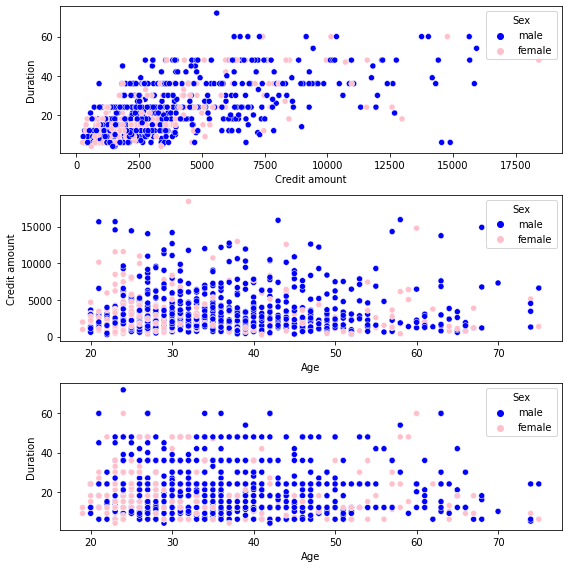

In [8]:
scatters(credit_data, h="Sex", pal=['blue', 'pink'])

En general, las mujeres registradas tienden a ser menores que sus contraparte masculinas, aún así, la diferenciación entre
sexos en el primer gráfico no es evidente en terminos de monto y duración del crédito. De momento se puede suponer 
correlaciones aproximadamente positivas.

A continuación se comprobará la significancia de la correlación entre monto y duración de crédito

(0.6249841983009835, 1.8628512880465833e-109)


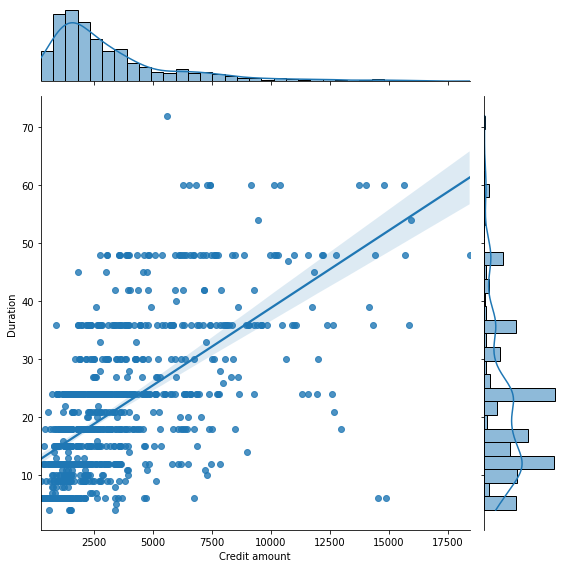

In [9]:
reg_1 = sns.jointplot(x='Credit amount', y='Duration', data=credit_data, kind='reg', height=8)
print(stats.pearsonr(x=credit_data['Credit amount'], y=credit_data['Duration']))
plt.show()

Se obtuvo una correlación significativa baja-moderada. Esto hace sentido en cuanto los montos de los créditos crecen,
las personas tienden a aumentar sus duraciones.
Ahora se va a mostrar la misma regresión, pero incluyendo algunos estratos.

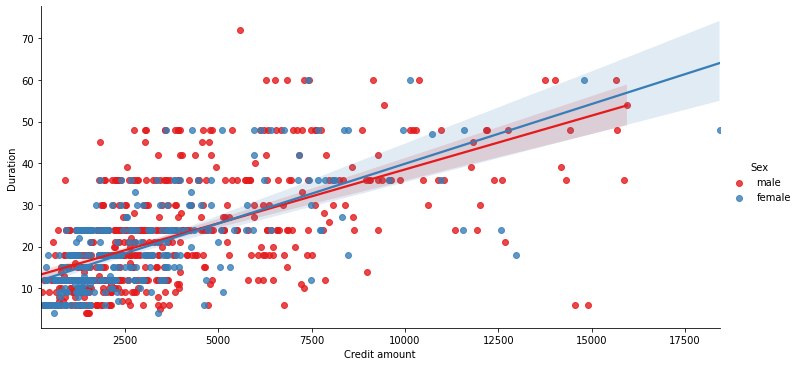

In [10]:
plot_1 = sns.lmplot(x='Credit amount', y='Duration', hue='Sex', data=credit_data, palette='Set1', aspect=2)
plt.show()

Tras una inspección visual de las bandas de confianza, se puede concluir que no existen diferencias entre sexos. Sin 
embargo, se debería revisar las estimaciones por la evidente heterocedasticidad.

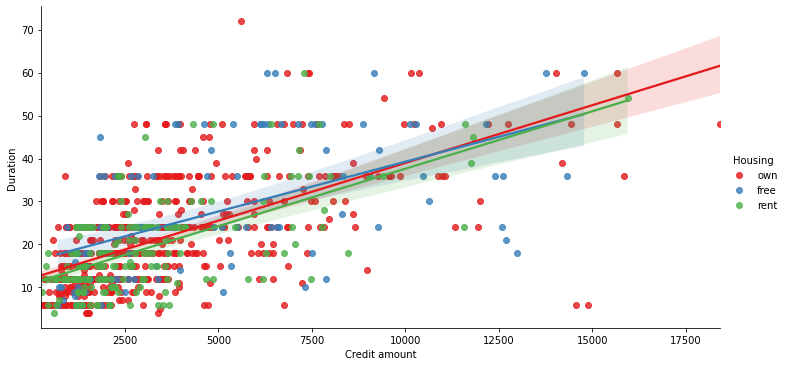

In [11]:
sns.lmplot(x='Credit amount', y='Duration', hue='Housing', data=credit_data, palette='Set1', aspect=2)
plt.show()

Nuevamente no se encuentran diferencias entre categórias.
Abajo se muestran el areá de "negocios" donde se dieron las mayores cantidades de créditos.

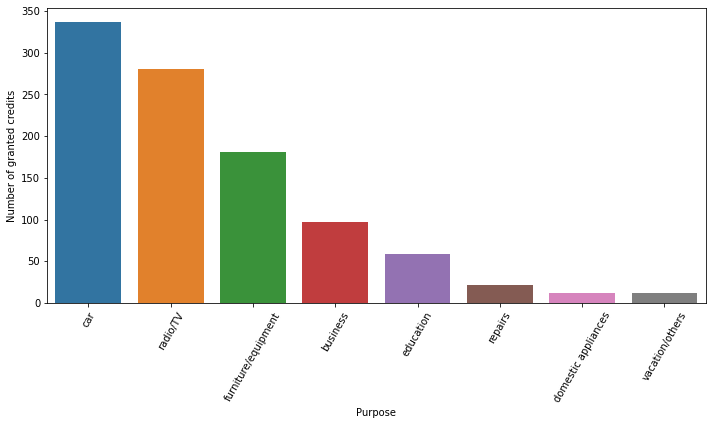

In [12]:
n_credits = credit_data.groupby('Purpose')['Age'].count().rename('Count').reset_index()
n_credits.sort_values(by=['Count'], ascending=False, inplace=True)

plt.figure(figsize=(10,6))
bar = sns.barplot(x='Purpose', y='Count',data=n_credits)
bar.set_xticklabels(bar.get_xticklabels(), rotation=60)
plt.ylabel('Number of granted credits')
plt.tight_layout()

Arriba se muestra la cantidad de créditos otorgados por proposito. 

Ahora se generarán los boxplot para en analísis detallado de las variables categóricas.

In [13]:
def boxes(x,y,h,r=45):
    fig, ax = plt.subplots(figsize=(10,6))
    box = sns.boxplot(x=x, y=y, hue=h, data=credit_data)
    box.set_xticklabels(box.get_xticklabels(), rotation=r)
    fig.subplots_adjust(bottom=0.2)
    plt.tight_layout()

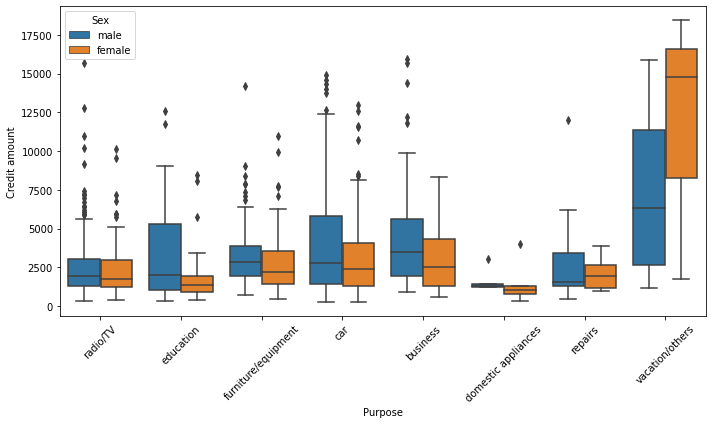

In [14]:
boxes('Purpose', 'Credit amount', 'Sex')

La categória con acumulación de mayores valores y variación es vacations/others, mientras que domestic appliances agrupa 
los menores valores. La mayoría muestran una distribución asímetrica positiva. Además, no se nota una separación clara 
(excepto en las colas) entre hombres y mujeres para todos los casos, salvo vacation/others.
Nota: La categória con menos cantidad de créditos solicitados fue vacation/others.

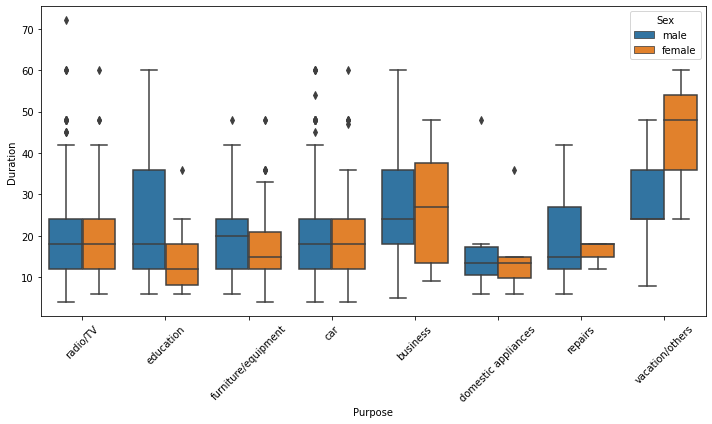

In [15]:
boxes('Purpose', 'Duration', 'Sex')

Respecto a los boxplot para duraciones se obtienen conclusiones parecidas a las realizadas sobre los montos, aunque las
diferencias entre sexos tienden a poseerr una menor acentuación, exceptuando vacation/others.

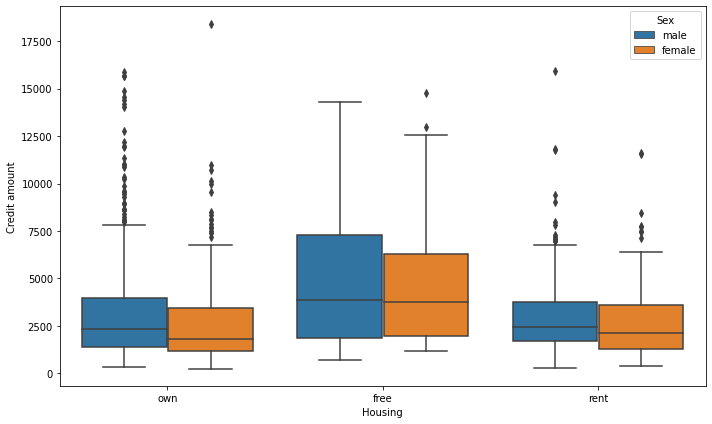

In [16]:
boxes('Housing', 'Credit amount', 'Sex', r=0)

En terminos de créditos de viviendo, las categórias de "own" y "rent" presentan bastantes similitudes, aún así, la primera
de ellas tiene mayor probabilidad de presentar créditos de mayores montos (Sin ser que está sea una proporción 
significativa de la distribución). Las personas que adquieren un créditos del tipo 'free' presentan un mayor rango de 
montos, reflejando una mayor dispersión.

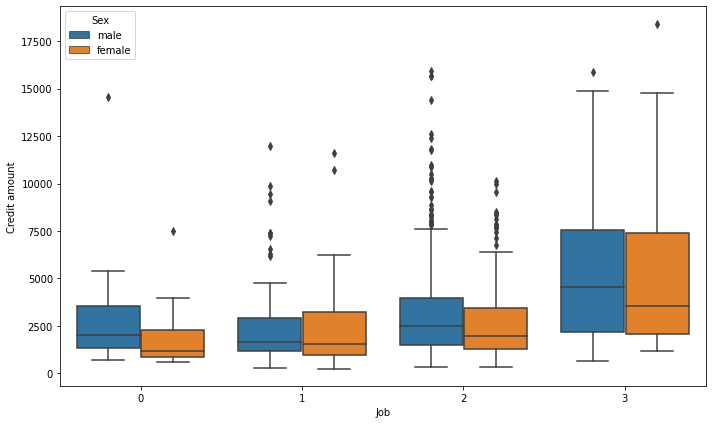

In [17]:
boxes('Job', 'Credit amount', 'Sex', r=0)

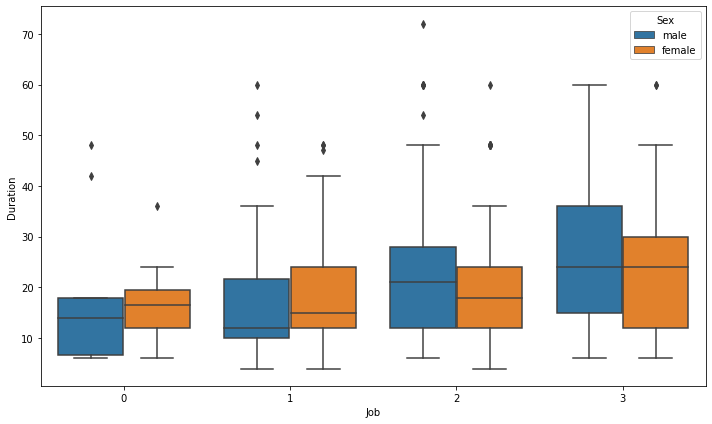

In [18]:
boxes('Job', 'Duration', 'Sex', r=0)

En lo que concierne a la clasificación por Job, aquellos del grupo 3, es decir, personas con un trabajo altamente 
especializado y en consecuencia (Aunque no necesariamente) mejores pagos, tienden a preferir créditos de mayores montos y
duraciones

Se finaliza con una gráfica 3D.

Text(0.5, 0, 'Age')

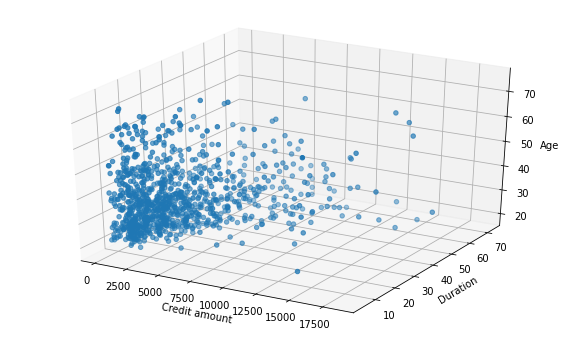

In [19]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(credit_data['Credit amount'], credit_data['Duration'], credit_data['Age'])
ax.set_xlabel('Credit amount')
ax.set_ylabel('Duration')
ax.set_zlabel('Age')

# Clustering

## Clustering con KMeans

Para esta metodología se reduce el conjunto de datos a las variables númericas (menos Job que es cualitativa)

In [20]:
selected_cols = ['Age', 'Credit amount', 'Duration']
cluster_data = credit_data.loc[:, selected_cols]

Con la siguiente función se gráficaran los histogramas 

In [21]:
def distributions(df):
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,8))
    sns.histplot(df['Age'], ax=ax1)
    sns.histplot(df['Credit amount'], ax=ax2)
    sns.histplot(df['Duration'], ax=ax3)
    plt.tight_layout()

Ahora los histogramas.

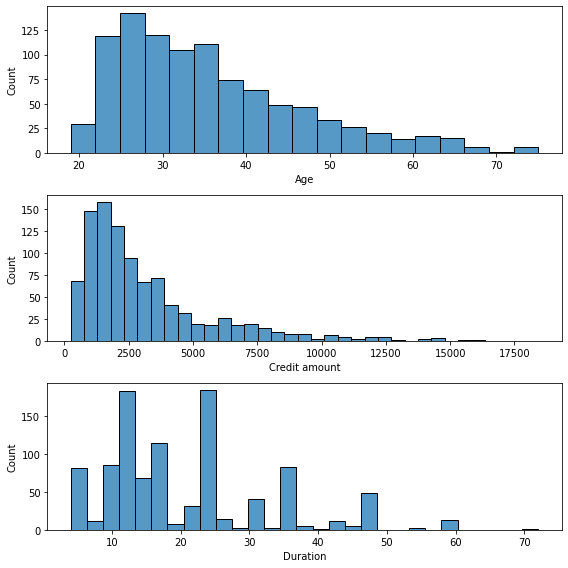

In [22]:
distributions(cluster_data)

Se tiene una distribución con sesgo a derecha. Para mejorar el algoritmo de clustering se aplicán logs (para conservar 
una interpretación simple) como se ve a continuación

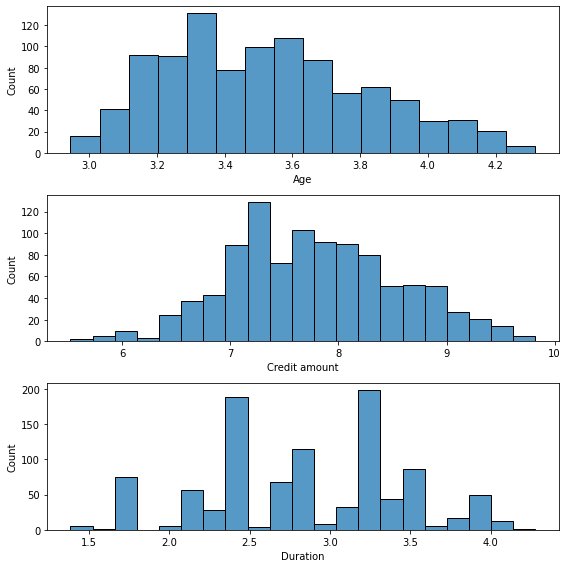

In [23]:
cluster_log = np.log(cluster_data)
distributions(cluster_log)

Ya con 'simetría' aproximada se procede a estandarizar

In [24]:
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster_log)

A continuación se realiza un análisis de silhouette, donde se obetendrá su score promedio en diferentes semillas, para 
luego ser resumidos en un promedio general.

In [25]:
clusters_range = range(2,15)
random_range = range(0,15)
for c in clusters_range:
    results = np.empty(15)
    for r in random_range:
        clusterer = KMeans(n_clusters=c, random_state=r)
        cluster_labels = clusterer.fit_predict(cluster_scaled)
        silhouette_avg = silhouette_score(cluster_scaled, cluster_labels)
        results[r] = silhouette_avg
    print("For n_clusters =", c,". The average silhouette_score is: ", np.mean(results))


For n_clusters = 2 . The average silhouette_score is:  0.3153441336069186
For n_clusters = 3 . The average silhouette_score is:  0.30302368891608994
For n_clusters = 4 . The average silhouette_score is:  0.2675268433663984
For n_clusters = 5 . The average silhouette_score is:  0.26719793212065035
For n_clusters = 6 . The average silhouette_score is:  0.2610621025307371
For n_clusters = 7 . The average silhouette_score is:  0.2580243429917325
For n_clusters = 8 . The average silhouette_score is:  0.25810195952990883
For n_clusters = 9 . The average silhouette_score is:  0.25269808260648546
For n_clusters = 10 . The average silhouette_score is:  0.253671038082267
For n_clusters = 11 . The average silhouette_score is:  0.25588758592657507
For n_clusters = 12 . The average silhouette_score is:  0.25267795835090257
For n_clusters = 13 . The average silhouette_score is:  0.2528992821580787
For n_clusters = 14 . The average silhouette_score is:  0.251477613744245


Los mayores valores se obtienen de usar 2 a 3 clusters. Priorizando una clasificación informativa, se utilizan 3 clusters
como opción principal. En adición, se explora el uso de 4 clusters como opción secundaria

Se define una función para gráficar las siluetas (código modificado de scikit-learn docs).

In [26]:
def silhouette_graph(data, n_clusters, seed=1):
    clusterer = KMeans(n_clusters=n_clusters, random_state=seed)
    cluster_labels = clusterer.fit_predict(data)
    silhouette_avg = silhouette_score(data, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(data, cluster_labels)

    fig, ax1 = plt.subplots(figsize=(10,6))

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),0, ith_cluster_silhouette_values, facecolor=color, edgecolor="black", alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.get_yaxis().set_ticks([])
    ax1.set_title("The silhouette plot for various clusters")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

Para 3 clusters

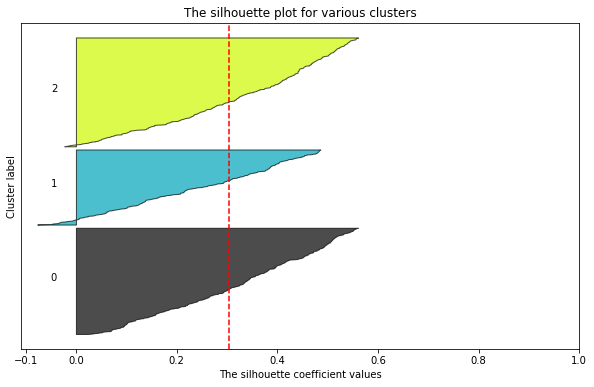

In [27]:
silhouette_graph(data=cluster_scaled, n_clusters=3, seed=3)

Para 4 clusters

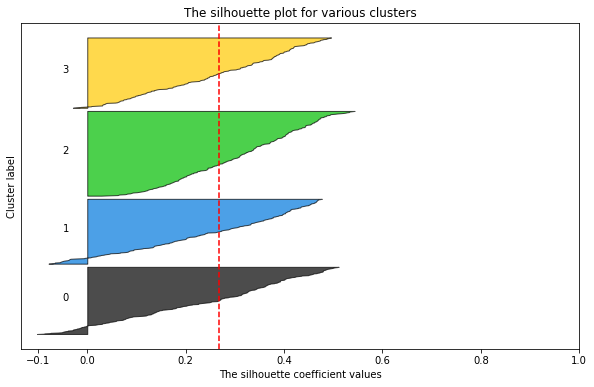

In [28]:
silhouette_graph(data=cluster_scaled, n_clusters=4, seed=3)

Ahora veamos como se visualizan los clusters en pares de scatterplots.  

In [29]:
kmeans_sel_clus3 = KMeans(n_clusters=3, random_state=1).fit(cluster_scaled)
labels_clus3 = pd.DataFrame(kmeans_sel_clus3.labels_)
clustered_data_clus3 = cluster_data.assign(Cluster=labels_clus3)
kmeans_sel_clus4 = KMeans(n_clusters=4, random_state=1).fit(cluster_scaled)
labels_clus4 = pd.DataFrame(kmeans_sel_clus4.labels_)
clustered_data_clus4 = cluster_data.assign(Cluster=labels_clus4)

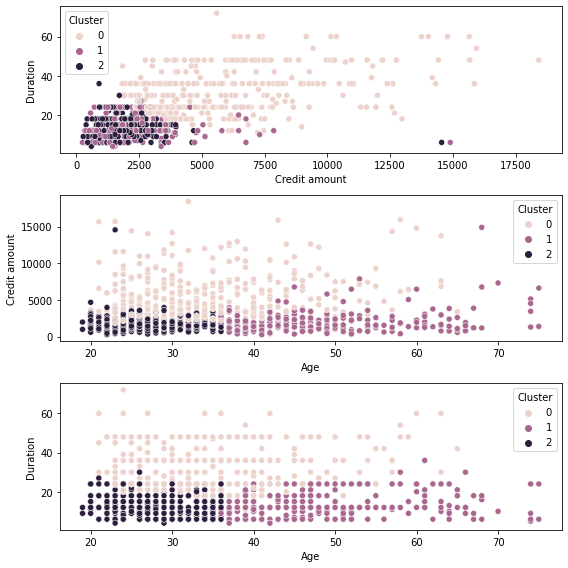

In [30]:
scatters(clustered_data_clus3, 'Cluster')

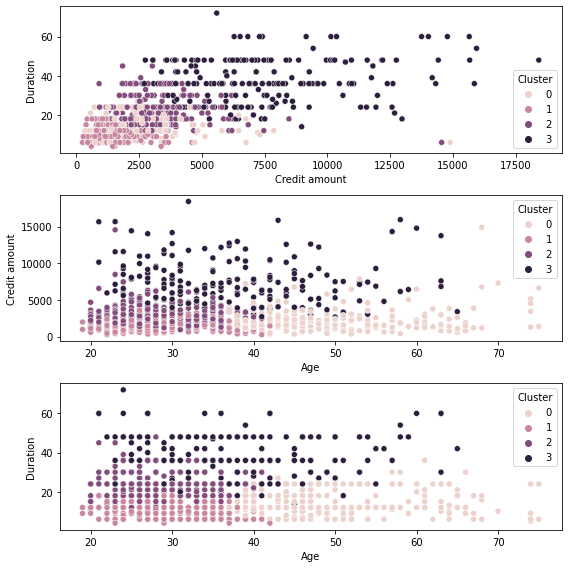

In [31]:
scatters(clustered_data_clus4, 'Cluster')

La segmentación es clara en los dos últimos pares. Para reducir la ambigüedad se presentaran los gráficos 3D

Text(0.5, 0, 'Age')

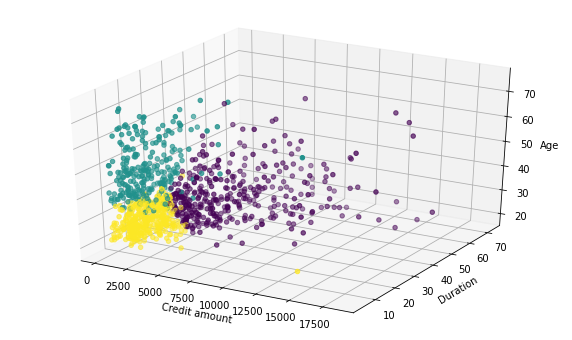

In [32]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(credit_data['Credit amount'], credit_data['Duration'], credit_data['Age'], 
           c=np.array(clustered_data_clus3['Cluster']))
ax.set_xlabel('Credit amount')
ax.set_ylabel('Duration')
ax.set_zlabel('Age')

Text(0.5, 0, 'Age')

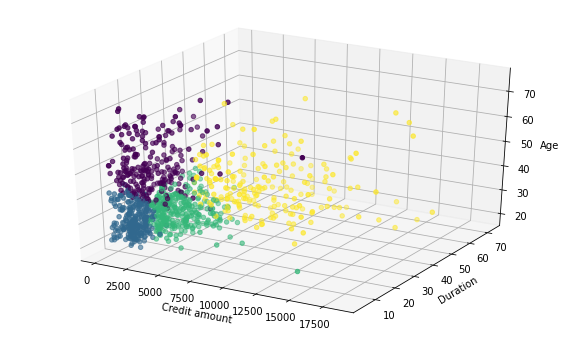

In [33]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(credit_data['Credit amount'], credit_data['Duration'], credit_data['Age'], 
           c=np.array(clustered_data_clus4['Cluster']))
ax.set_xlabel('Credit amount')
ax.set_ylabel('Duration')
ax.set_zlabel('Age')

La representación anterior resulta más informativa que los gráficos sencillos. Ahora se mostrara un resumen de los clusters
y la interpretación que se le da para objetivos comerciales

In [34]:
clustered_data_clus3.groupby(['Cluster']).agg(['mean', 'std']).round(1)

Age      Credit amount         Duration      
         mean  std          mean     std     mean   std
Cluster                                                
0        34.0  8.9        5665.4  3067.4     32.2  11.1
1        48.7  9.7        1979.7  1517.6     13.9   6.4
2        27.8  4.6        1732.2  1044.6     14.2   5.6

Cluster 0 –  Clientes de media edad con créditos de larga duración y montos altos.

Cluster 1 – Clientes Senior con créditos de corta duración y montos bajos.

Cluster 2 - Clientes jovénes con créditos de corta duración y montos bajos.

In [35]:
clustered_data_clus4.groupby(['Cluster']).agg(['mean', 'std']).round(1)

Age      Credit amount         Duration      
         mean  std          mean     std     mean   std
Cluster                                                
0        50.1  9.4        2183.7  1611.1     14.9   6.3
1        29.1  5.6        1354.9   663.3     10.6   3.5
2        28.7  4.8        2930.6  1416.1     22.6   6.5
3        37.0  9.6        7279.8  3112.7     37.5  11.1

Cluster 0 –  Clientes Senior con créditos de corta-media duración y montos bajos-medios.

Cluster 1 – Clientes jovénes con créditos de corta duración y montos bajos.

Cluster 2 - Clientes jovénes con créditos de duración media y montos medios.

Cluster 3 - Clientes de mediana edad con créditos de larga duración y montos altos.

## Clustering con K-prototypes

Para K-prototypes se procede con todas las variables

<function matplotlib.pyplot.show>

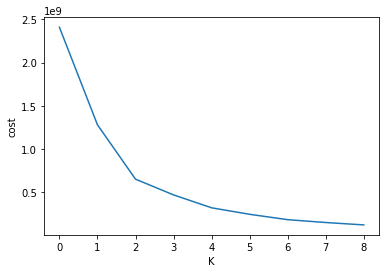

In [36]:
cost = []
categorical = categorical_col = [1,2,3,4,5,8]
for num_clusters in list(range(2,11)):
    kproto = KPrototypes(n_clusters=num_clusters, init='Cao', random_state=3, 
                         n_jobs=-1, max_iter=20, n_init=50) 
    kproto.fit_predict(credit_data, categorical=categorical_col)
    cost.append(kproto.cost_)

plt.plot(cost)
plt.xlabel('K')
plt.ylabel('cost')
plt.show

Dado que dos clusters son pocos, voy a optar por irme por cuatro

In [37]:
kproto = KPrototypes(n_clusters=4, init='Huang', verbose=0, random_state=3,max_iter=20, n_init=50,n_jobs=-2) 
clusters = kproto.fit_predict(credit_data, categorical=categorical_col)

Ahora veamos la distribución de los clientes en los clusters propuestos

In [38]:
credit_data_wkp = credit_data.copy()
credit_data_wkp['Cluster_id_K_Prototype']=clusters
print (credit_data_wkp['Cluster_id_K_Prototype'].value_counts())

2    543
1    285
3    130
0     42
Name: Cluster_id_K_Prototype, dtype: int64


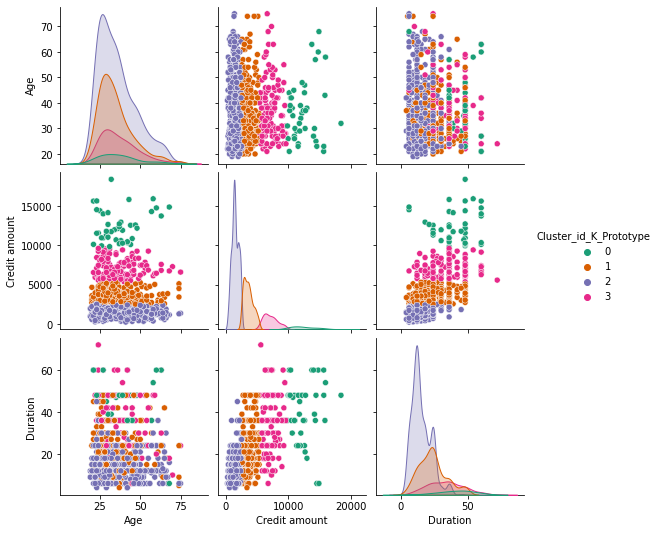

In [39]:
sns.pairplot(credit_data_wkp.drop(columns='Job'),hue='Cluster_id_K_Prototype', palette='Dark2', diag_kind='kde')

Con esto procedemos a crear un resumen para los cuatro clusters

In [40]:
categorical_col_names = credit_data_wkp.columns.to_list()
categorical_col_names = [categorical_col_names[i] for i in categorical_col]
resume_categorical = credit_data_wkp.groupby('Cluster_id_K_Prototype')[
  categorical_col_names].agg(lambda x:x.value_counts().index[0])
resume_numerical = credit_data_wkp.drop(columns='Job').groupby('Cluster_id_K_Prototype').mean()
resume_categorical.join(resume_numerical)

,Sex,Job,Housing,Saving accounts,Checking account,Purpose,Age,Credit amount,Duration
Cluster_id_K_Prototype,,,,,,,,,
0,male,3,own,little,moderate,car,36.666667,12511.714286,40.261905
1,male,2,own,little,none,car,34.673684,3583.589474,23.505263
2,male,2,own,little,none,radio/TV,35.616943,1469.364641,15.060773
3,male,2,own,little,none,car,36.800000,7127.523077,33.346154


Se puede ver que a diferencia de K-means, en este tipo de agrupamiento la edad no es un factor relevante para definir los grupos y cuyas carácteristicas principales son:

Cluster 0 –  Clientes con trabajos especializados, que poseen una cuenta corriente y han tenido créditos de larga duración y montos altos.

Cluster 1 – Clientes que han tenido créditos de corta duración y montos medio-bajos.

Cluster 2 - Clientes que han adquirido créditos de corta duración y montos bajos para adquirir electrodomesticos.

Cluster 3 - Clientes que han tenido créditos de media duración y montos medio-altos.

Text(0.5, 0, 'Age')

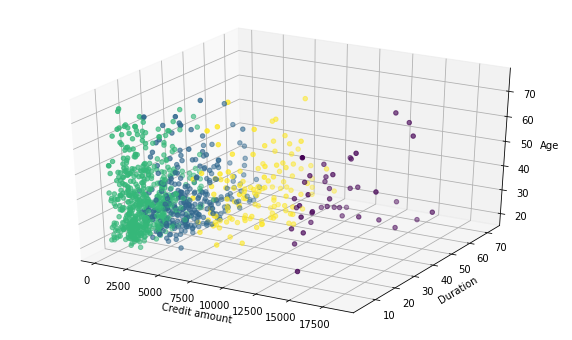

In [41]:
# Gráfica para K-Proto
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(credit_data['Credit amount'], credit_data['Duration'], credit_data['Age'], 
           c=clusters)
ax.set_xlabel('Credit amount')
ax.set_ylabel('Duration')
ax.set_zlabel('Age')

Se puede ver que los productos previos son un factor determinante en la creación de nuestros grupos. 

# Clasificación

**Encoding**

Antes de proponer algún modelo de clasificación, es necesario codificar las variables categóricas utilizando un One-Hot Encoder

In [42]:
# Pre-procesamiento
wkp_encod = pd.get_dummies(credit_data_wkp, columns=['Sex', 'Job', 'Housing',
                                                     'Saving accounts',
                                                     'Checking account',
                                                     'Purpose'])

Dada la codificación se procede a separar las variables utilizadas por el modelo y su objetivo, es decir, el cluster al que pertenencen

In [43]:
# Split features - objetive
X = wkp_encod.drop(columns='Cluster_id_K_Prototype')
y = wkp_encod['Cluster_id_K_Prototype']

Acá voy a crear una división entre conjuntos de entrenamiento y prueba, usando una repartición del 70% / 30% de forma respectiva

In [44]:
# Split train - test
X_train, X_test, y_train, y_test = train_test = train_test_split(X, y, test_size = 0.3)

Luego, uso un modelo clasificador de Random Forest para mis procedimientos. Primero intento optimizar sus hiperparámetros mediante una busqueda aleatoria

In [45]:
# Grilla de parametros
param_grid = {
  'n_estimators':np.arange(20,220,20),
  'max_samples':np.arange(0.4, 1.15, 0.15),
  'max_depth':np.arange(4, 44, 4)
}

In [46]:
# Definir el RSCV
clf_rscv = RandomizedSearchCV(RandomForestClassifier(), param_grid, 
                              scoring='accuracy', 
                              n_jobs=-1)

In [47]:
# Ajustar a los datos
clf_rscv.fit(X_train, y_train)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
            

A continuación se muestran los mejores parámetros que obtienen el mejor puntaje de presición entre todos los modelos explorados

In [48]:
# Mejores parámetros
clf_rscv.best_params_

{'max_depth': 20, 'max_samples': 0.8500000000000001, 'n_estimators': 200}

In [49]:
# Ajute del mejor modelo
best_model = clf_rscv.best_estimator_
best_model.fit(X_train, y_train)
prediction = best_model.predict(X_test)

Finalmente voy a presentar las matrices de confusión obtenidas dentro de entrenamiento y prueba. Concluyendo con la presentación de la presición observada en prueba

In [50]:
# Matriz de confusión en train
confusion_matrix(y_train, best_model.predict(X_train))

array([[ 22,   0,   0,   0],
       [  0, 206,   0,   0],
       [  0,   0, 380,   0],
       [  0,   0,   0,  92]])

In [51]:
# Matriz de confusión en test
confusion_matrix(y_test, prediction)

array([[  3,   0,   0,  17],
       [  0,  79,   0,   0],
       [  0,   0, 163,   0],
       [  0,   4,   0,  34]])

In [52]:
# Accuaracy
accuracy_score(y_test, prediction)

0.93